# 🔧 Handling Missing Values

This notebook focuses on identifying and handling missing values in the Titanic dataset  
to ensure accurate analysis and modeling in future steps.

---

## 🎯 Purpose

To detect missing values, explore their patterns,  
and apply appropriate strategies such as removal or imputation.

## 📦 Dataset

Same dataset as the previous notebook:  
[Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)  
via public repository: [Data Science Dojo GitHub](https://github.com/datasciencedojo/datasets)

📦 1. Load the Dataset

In [212]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')

# Load Titanic dataset
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


🔍 2. Check for Missing Values

In [213]:
# Check missing values in each column
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- While most columns have complete data,<br>
`Age`, `Cabin`, and `Embarked` contain missing values that must be addressed.  
- Although `Embarked` has very few missing entries, they still need to be handled for modeling consistency.

🧭 3. Choosing the Right Strategy for Missing Data

### Overview: Strategies for Handling Missing Values
Before handling specific columns,  
let’s briefly review the most common approaches for dealing with missing data.

| Strategy                  | Description                                                 | When to Use                                |
|---------------------------|-------------------------------------------------------------|--------------------------------------------|
| **Deletion**              | Remove rows or columns with missing values                 | When missing data is rare, unimportant, or too extensive to recover   |
| **Mean/Median Imputation**| Fill with the average or median of the column              | For numerical columns with moderate gaps   |
| **Mode Imputation**       | Fill with the most frequent category                       | For categorical data with few missing rows |
| **Constant/Custom Value** | Use a fixed placeholder or context-specific fill           | To clearly mark or flag missing cases      |
| **Model-based Imputation**| Predict missing values using other features                | When patterns exist and data is valuable   |
| **Treat as Category**     | Encode missing values as a new category                    | For tree-based models or interpretable encoding |

In this notebook, we will apply three different methods based on the characteristics of each variable:
- `Embarked` → mode imputation (categorical, few missing)
- `Age` → median imputation (numeric, moderate missing)
- `Cabin` → deletion or feature engineering (mostly missing)

🛠 4. Handling Missing Values in Practice

4-1. Embarked (Categorical, Few Missing)<br>

`Embarked` is a categorical variable with only a few missing values.  
Since it's nominal and the number of missing rows is very small,  
we can safely fill them with the most frequent category (mode).

In [214]:
# Check value counts before imputation
df['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [215]:
# Fill missing values with the most frequent category (mode)
mode_embarked = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(mode_embarked)

In [216]:
# Verify that there are no missing values left
df['Embarked'].isnull().sum()

np.int64(0)

4-2. Age (Numerical, Moderately Missing)<br>

`Age` is a numerical feature with a moderate amount of missing values.  
Since age is an important variable in survival analysis, we will fill the missing values with the **median**,  
as it is more robust to outliers than the mean.

In [217]:
# Check number of missing values
df['Age'].isnull().sum()

np.int64(177)

In [218]:
# Fill missing values with the median
# median_age = df['Age'].median()
# df['Age'] = df['Age'].fillna(median_age)

While filling missing values in Age with the median is generally appropriate for numerical data with a moderate amount of missingness,<br> it may not be the best choice in this case.

Our previous analysis showed that Age is strongly correlated with survival.
Replacing nearly 20% of the values with a single number could distort the age distribution
and lead the model to learn incorrect patterns.

Therefore, we will impute the missing values based on Pclass and Sex
to better preserve the underlying structure of the data.

In [219]:
# First, check group medians
df.groupby(['Pclass', 'Sex'])['Age'].median()


Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

In [220]:
# Apply group-based imputation
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

In [221]:
# Confirm that no missing values remain
df['Age'].isnull().sum()

np.int64(0)

4-3. Cabin (Mostly Missing)

`Cabin` has over 75% missing values, making it unreliable for direct imputation.  
In this case, there are two reasonable options:

- **Drop the column**, as it's mostly empty and may add noise.
- **Extract the first letter (cabin section)** as a new feature, and treat missing as a separate category.

For this notebook, we’ll extract the first letter of the cabin (e.g., 'C123' → 'C')  
and fill missing values with 'U' for 'Unknown'.

In [222]:
# Check number of missing values
df['Cabin'].isnull().sum()

np.int64(687)

In [223]:
# Extract the first letter of the cabin (e.g., 'C123' → 'C')
df['Cabin_initial'] = df['Cabin'].str[0]

# Fill missing values with 'U' for 'Unknown'
df['Cabin_initial'] = df['Cabin_initial'].fillna('U')

In [224]:
# Confirm that no missing values remain
df['Cabin'].isnull().sum()

np.int64(0)

🧪 5. Analyze Survival by Cabin Section

In the previous exploratory analysis, we skipped the `Cabin` variable due to excessive missing values.  
Now that we’ve extracted usable information and handled the missing data,  
we can finally explore whether different cabin sections are related to survival outcomes.

We’ll use the first letter of each cabin (e.g., A, B, C...) to represent cabin sections.

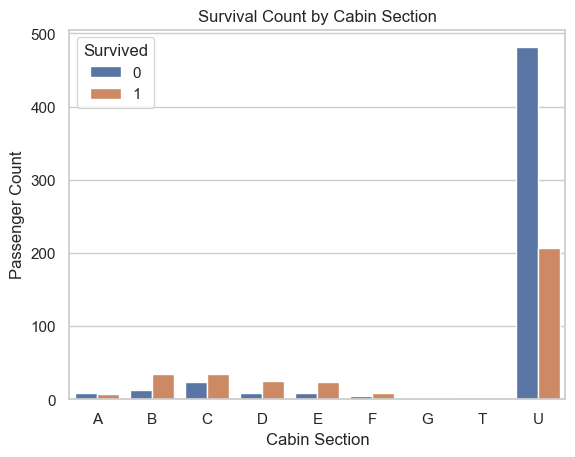

In [225]:
# Survival count by cabin section
sns.countplot(x='Cabin_initial', hue='Survived', data=df, order=sorted(df['Cabin_initial'].unique()))
plt.title('Survival Count by Cabin Section')
plt.xlabel('Cabin Section')
plt.ylabel('Passenger Count')
plt.show()

- Most passengers with missing cabin information (represented by 'U') had lower survival rates,  
while certain sections like B, C, and E showed notably higher survival.

- This suggests that cabin location — likely linked to ticket class or location on the ship —  
may have influenced survival, and even missingness itself could carry meaningful information.

## 🧠 Summary

In this notebook, we focused on handling missing values across multiple variables  
and explored how imputation choices affect analysis outcomes.

**Key actions taken:**

- **Embarked**: Filled with the most frequent value (mode),  
  as the number of missing entries was small and the variable was categorical.

- **Age**: Initially filled with the median, but updated using group-specific medians  
  based on `Pclass` and `Sex` to better preserve its relationship with survival.

- **Cabin**: Over 75% of values were missing.  
  We extracted the first letter as a new categorical feature and replaced missing values with `'U'` (Unknown).  
  This allowed us to include the variable in survival analysis and uncover patterns hidden by missing data.

**Insight:**  
Different strategies were applied depending on each variable’s type, importance, and missingness ratio.  
This flexible and thoughtful approach helped improve data quality while preserving structure for future modeling.
